# PCAP Feature Extractor

This notebook outlines the process of extracting network flow features from PCAP files and visualizing them to identify potential Distributed Denial of Service (DDoS) attack signatures. It serves as a guide for analyzing suspicious network behavior.

### Environment Setup
The initial environment setup installs necessary system-level development headers for `libpcap` and then proceeds to install the `PCAP-Feature-Extractor` library from its GitHub repository via `pip`. The `libpcap` Python binding is also installed.

* Github Repository link: https://github.com/adrianstanea/PCAP-Feature-Extractor.git

In [ ]:
# 1. Install the system-level libpcap development headers: needed for scapy python binary which does not link properly with libcap.so
!apt-get update
!apt-get install -y libpcap-dev

!pip install --upgrade --force-reinstall --no-cache-dir git+https://github.com/adrianstanea/PCAP-Feature-Extractor.git
!pip install libpcap

### `pcap_features` CLI interface:

Before proceeding, examining the command-line interface (CLI) of the `pcap_features` tool is essential to understand its available options and arguments. The next step will display the tool's help documentation.

Executing `pcap_features --help` displays the command-line interface options for the tool. This output details how to specify an input PCAP file (`-f`), output to CSV (`-c`), select specific fields (`--fields`), and enable verbose mode (`-v`), providing a clear guide for its usage.

In [ ]:
!pcap_features --help

usage: pcap_features [-h] -f INPUT_FILE -c [--fields FIELDS] [-v] output

positional arguments:
  output                output file name (in CSV mode)

options:
  -h, --help            show this help message and exit
  -f INPUT_FILE, --file INPUT_FILE
                        capture offline data from INPUT_FILE
  -c, --csv             output flows as csv
  --fields FIELDS       comma separated fields to include in output (default:
                        all)
  -v, --verbose         more verbose


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Users have the option to apply the feature extraction script to a PCAP file sourced from either Google Drive or a manual upload. To expedite analysis in subsequent runs, it's possible to skip this step if a CSV output from a previous execution is already available, leveraging the persistent storage of results.

In [ ]:
!pcap_features --filefile /content/drive/MyDrive/dataset/CICDDoS2019/PCAP-03-11/SAT-03-11-2018_0 --csv /content/drive/MyDrive/dataset/CICDDoS2019/PCAP-03-11/SAT-03-11-2018_0.csv

reading from file /content/drive/MyDrive/dataset/CICDDoS2019/PCAP-03-11/SAT-03-11-2018_0, link-type EN10MB (Ethernet), snapshot length 262144


Feature extraction from the specified PCAP file (`SAT-03-11-2018_0`) located on Google Drive is performed using the `pcap_features` tool. The `--csv` flag ensures that the extracted network flow features are saved into a new CSV file, also on Google Drive. This conversion of raw network traffic into a structured format is a critical preparatory step for subsequent analysis.

In [ ]:
import numpy as np
import pandas as pd

# Base Libraries
import matplotlib.pyplot as plt
import matplotlib.figure as fgr
from matplotlib.pyplot import figure
import seaborn as sns
import time
import os

This cell defines the `csv_filepath` variable, pointing to the CSV file generated by the `pcap_features` script. It then uses `pd.read_csv()` to load the data from this CSV file into a pandas DataFrame named `df`.

In [ ]:
csv_filepath = "/content/drive/MyDrive/dataset/CICDDoS2019/PCAP-03-11/SAT-03-11-2018_0.csv"
df = pd.read_csv(csv_filepath)

The dimensions of the loaded DataFrame (`df`) are displayed, providing an immediate overview of the dataset's size. The output indicates that `189734` network flows were extracted, with each flow described by `68` distinct features.

In [ ]:
num_entries, num_features = df.shape
print(f"Extracted {num_entries} entries with {num_features} features/entry")

Extracted 189734 entries with 68 features/entry


### Overview of the processed features

This cell displays the first 10 rows of the DataFrame using `df.head(10)`. This provides a sneak peek into the data, showing the various network flow features (like source/destination IP/port, protocol, timestamp, flow duration, packet lengths, etc.) and their values. It helps in understanding the format and content of the extracted features.

In [ ]:
df.head(10)

,src_ip,dst_ip,src_port,dst_port,protocol,timestamp,flow_duration,flow_iat_mean,flow_iat_std,flow_iat_min,...,fwd_pkt_len_min,bwd_pkt_len_mean,bwd_pkt_len_std,bwd_pkt_len_max,bwd_pkt_len_min,pkt_len_mean,pkt_len_std,pkt_len_var,pkt_len_max,pkt_len_min
0,192.168.50.6,172.217.10.98,54799,443,6,2018-11-03 12:18:18,36.435473,4.554434,12.026317,0.0,...,60,100.0,0.0,100,100,82.222222,19.876160,395.061728,100,60
1,192.168.50.6,172.217.7.2,54800,443,6,2018-11-03 12:18:18,36.434705,4.554338,12.026064,0.0,...,60,100.0,0.0,100,100,82.222222,19.876160,395.061728,100,60
2,192.168.50.6,172.217.10.98,54801,443,6,2018-11-03 12:18:18,36.434626,4.554328,12.026040,0.0,...,60,100.0,0.0,100,100,82.222222,19.876160,395.061728,100,60
3,192.168.50.6,172.217.9.238,54805,80,6,2018-11-03 12:18:18,0.041252,0.006875,0.015284,0.0,...,60,60.0,0.0,60,60,60.000000,0.000000,0.000000,60,60
4,0.0.0.0,255.255.255.255,68,67,17,2018-11-03 12:18:18,28.870362,5.774072,4.214344,0.0,...,342,0.0,0.0,0,0,342.000000,0.000000,0.000000,342,342
5,192.168.50.6,172.217.10.65,54802,443,6,2018-11-03 12:18:20,34.435249,4.304406,11.364851,0.0,...,60,100.0,0.0,100,100,82.222222,19.876160,395.061728,100,60
6,192.168.50.6,172.217.7.2,54803,443,6,2018-11-03 12:18:20,34.435196,4.304399,11.364835,0.0,...,60,100.0,0.0,100,100,82.222222,19.876160,395.061728,100,60
7,192.168.50.6,172.217.12.206,54804,443,6,2018-11-03 12:18:20,34.425788,4.303223,11.361731,0.0,...,60,100.0,0.0,100,100,82.222222,19.876160,395.061728,100,60
8,192.168.50.9,35.158.163.158,57658,443,6,2018-11-03 12:18:26,0.107584,0.008965,0.029645,0.0,...,66,66.0,0.0,66,66,81.384615,19.986682,399.467456,112,66
9,192.168.50.9,54.192.55.39,37652,443,6,2018-11-03 12:18:26,0.039502,0.003292,0.010746,0.0,...,66,66.0,0.0,66,66,81.384615,19.986682,399.467456,112,66


This cell uses `df.info()` to print a concise summary of the DataFrame. This includes:
- The number of entries (rows).
- The total number of columns.
- A list of all columns, along with their non-null count and data type (`Dtype`).
- The memory usage of the DataFrame.

This output is very useful for quickly checking data types, identifying columns with missing values (if any), and understanding the overall structure of the dataset. In this case, all columns have `189734` non-null values, indicating no missing data after the feature extraction process.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189734 entries, 0 to 189733
Data columns (total 68 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   src_ip             189734 non-null  object 
 1   dst_ip             189734 non-null  object 
 2   src_port           189734 non-null  int64  
 3   dst_port           189734 non-null  int64  
 4   protocol           189734 non-null  int64  
 5   timestamp          189734 non-null  object 
 6   flow_duration      189734 non-null  float64
 7   flow_iat_mean      189734 non-null  float64
 8   flow_iat_std       189734 non-null  float64
 9   flow_iat_min       189734 non-null  float64
 10  flow_iat_max       189734 non-null  float64
 11  fwd_iat_mean       189734 non-null  float64
 12  fwd_iat_std        189734 non-null  float64
 13  fwd_iat_max        189734 non-null  float64
 14  fwd_iat_min        189734 non-null  float64
 15  fwd_iat_tot        189734 non-null  float64
 16  bw

This cell categorizes the DataFrame columns into 'Flow ID features' and 'Features'.
- `flow_ID`: Contains identifying information for each network flow (`src_ip`, `dst_ip`, `src_port`, `dst_port`, `protocol`). These are typically used to uniquely identify a flow and are often not directly used in feature engineering for models but are crucial for understanding the context of the flow.
- `features`: Contains all other columns, which represent the actual extracted metrics and statistics of the network flows (e.g., `timestamp`, `flow_duration`, `pkt_len_mean`). These are the features that will be used for analysis and potentially for training models.

This separation helps in organizing and understanding the different types of data available in the DataFrame.

In [ ]:
flow_ID = df.columns[:5]
features = df.columns[5:]

print(f"Flow ID features: {flow_ID}")
print(f"Features: {features}")

Flow ID features: Index(['src_ip', 'dst_ip', 'src_port', 'dst_port', 'protocol'], dtype='object')
Features: Index(['timestamp', 'flow_duration', 'flow_iat_mean', 'flow_iat_std',
       'flow_iat_min', 'flow_iat_max', 'fwd_iat_mean', 'fwd_iat_std',
       'fwd_iat_max', 'fwd_iat_min', 'fwd_iat_tot', 'bwd_iat_mean',
       'bwd_iat_std', 'bwd_iat_max', 'bwd_iat_min', 'bwd_iat_tot', 'idle_max',
       'idle_min', 'idle_mean', 'idle_std', 'active_max', 'active_min',
       'active_mean', 'active_std', 'init_fwd_win_byts', 'init_bwd_win_byts',
       'fwd_header_len', 'bwd_header_len', 'fwd_seg_size_min',
       'fwd_act_data_pkts', 'fwd_psh_flags', 'bwd_psh_flags', 'fwd_urg_flags',
       'bwd_urg_flags', 'fin_flag_cnt', 'syn_flag_cnt', 'rst_flag_cnt',
       'psh_flag_cnt', 'ack_flag_cnt', 'urg_flag_cnt', 'ece_flag_cnt',
       'tot_fwd_pkts', 'tot_bwd_pkts', 'flow_byts_s', 'flow_pkts_s',
       'fwd_pkts_s', 'bwd_pkts_s', 'down_up_ratio', 'totlen_fwd_pkts',
       'totlen_bwd_pkts', 'fwd

### Missing values

This cell iterates through each feature column (excluding the flow ID columns) and checks for missing values using `df[feature].isnull().sum()`. The output confirms that all features have `0` missing values, which means the dataset is complete and doesn't require imputation for any of the extracted features. This is a good indication of data quality from the feature extraction process.

In [ ]:
for feature in features:
    print(f"`{feature}` has {df[feature].isnull().sum()} missing values.")

`timestamp` has 0 missing values.
`flow_duration` has 0 missing values.
`flow_iat_mean` has 0 missing values.
`flow_iat_std` has 0 missing values.
`flow_iat_min` has 0 missing values.
`flow_iat_max` has 0 missing values.
`fwd_iat_mean` has 0 missing values.
`fwd_iat_std` has 0 missing values.
`fwd_iat_max` has 0 missing values.
`fwd_iat_min` has 0 missing values.
`fwd_iat_tot` has 0 missing values.
`bwd_iat_mean` has 0 missing values.
`bwd_iat_std` has 0 missing values.
`bwd_iat_max` has 0 missing values.
`bwd_iat_min` has 0 missing values.
`bwd_iat_tot` has 0 missing values.
`idle_max` has 0 missing values.
`idle_min` has 0 missing values.
`idle_mean` has 0 missing values.
`idle_std` has 0 missing values.
`active_max` has 0 missing values.
`active_min` has 0 missing values.
`active_mean` has 0 missing values.
`active_std` has 0 missing values.
`init_fwd_win_byts` has 0 missing values.
`init_bwd_win_byts` has 0 missing values.
`fwd_header_len` has 0 missing values.
`bwd_header_len` has

### Visualizing Temporal Dynamics (Timing Features)

This cell visualizes the distribution of two key timing features: `flow_duration` and `flow_iat_mean` (mean inter-arrival time). Histograms are used, and both x and y axes are set to a logarithmic scale (`log_scale=True`, `plt.xscale('log')`, `plt.yscale('log')`). This is critical because network flow durations and inter-arrival times can vary across many orders of magnitude (from microseconds to minutes or more). A logarithmic scale allows for better visualization of this wide range and helps in identifying patterns that might be obscured in a linear plot. The distributions give insights into how long flows typically last and how frequently packets within a flow arrive.

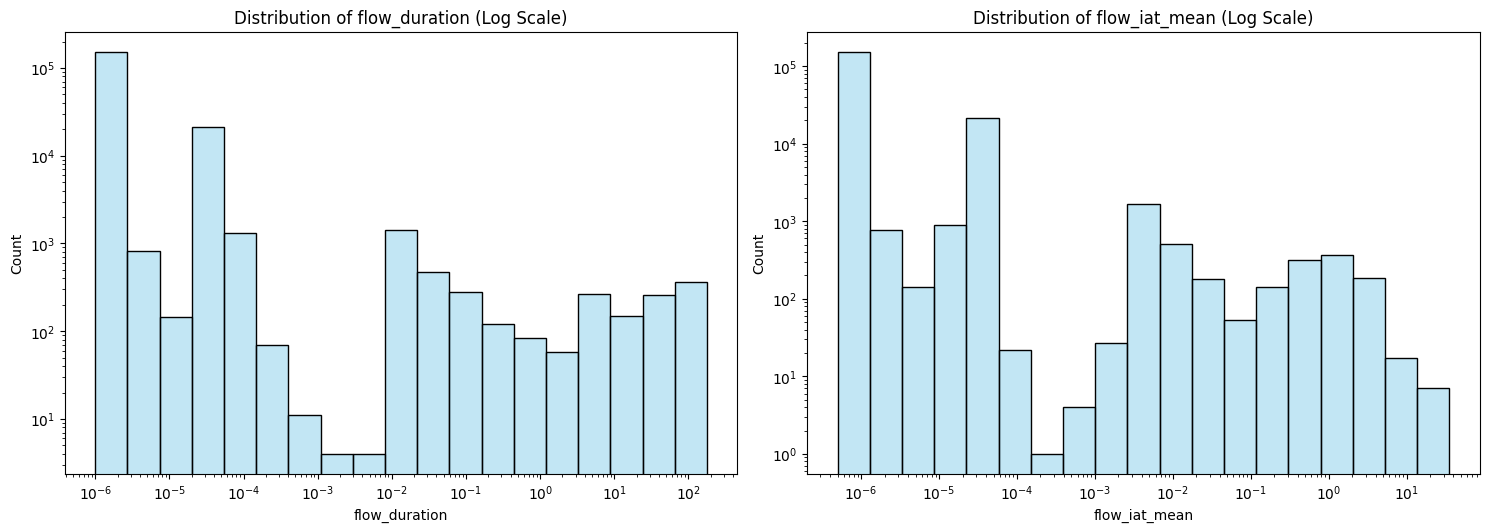

In [ ]:
# List of key timing features
timing_cols = ['flow_duration', 'flow_iat_mean']

plt.figure(figsize=(15, 10))
for i, col in enumerate(timing_cols):
    plt.subplot(2, 2, i+1)
    # Use log_scale=True because durations can range from microseconds to minutes
    sns.histplot(df[col], kde=True, color='skyblue', log_scale=True)
    plt.title(f'Distribution of {col} (Log Scale)')
    plt.xscale('log')  # Set x-axis to logarithmic scale
    plt.yscale('log')
plt.tight_layout()

This cell creates a histogram of `flow_iat_mean` (mean inter-arrival time) with a logarithmic scale, similar to the previous plot. However, it adds a specific visualization: a red shaded vertical area (`plt.axvspan`) between `1e-7` and `1e-3` seconds. This area is labeled as the 'High-Frequency Flooding Zone' and highlights where automated botnets or flood attacks typically operate due to their extremely low inter-arrival times. This plot helps in visually identifying potential attack traffic based on timing patterns.

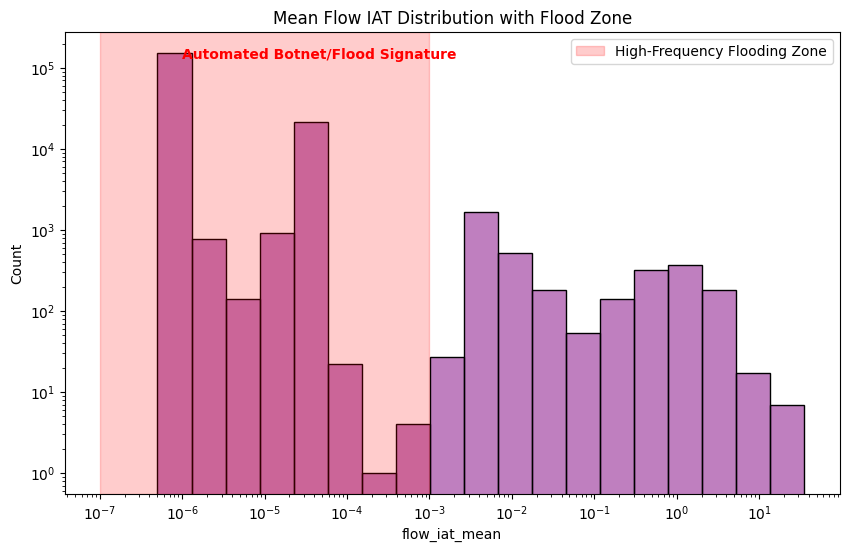

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['flow_iat_mean'], kde=True, log_scale=True, color='purple')

# Define a threshold for high-frequency flooding (e.g., < 0.001s)
plt.axvspan(1e-7, 1e-3, color='red', alpha=0.2, label='High-Frequency Flooding Zone')
plt.text(1e-6, plt.ylim()[1]*0.8, 'Automated Botnet/Flood Signature', color='red', weight='bold')

plt.title('Mean Flow IAT Distribution with Flood Zone')
plt.xscale('log')
plt.yscale('log')
plt.legend()

### Visualizing Volumetric Statistics (Rates & Outliers)

This cell uses box plots to visualize the distribution and identify outliers for selected volumetric features: `tot_fwd_pkts` (total forward packets), `tot_bwd_pkts` (total backward packets), `flow_byts_s` (flow bytes per second), and `flow_pkts_s` (flow packets per second). The `plt.yscale('log')` command applies a logarithmic scale to the y-axis, which is essential for effectively visualizing features that can have a very wide range of values, from small normal traffic to massive attack spikes. Outliers, often indicative of anomalous or malicious traffic, are clearly visible beyond the whiskers of the box plots.

([0, 1, 2, 3],
 [Text(0, 0, 'tot_fwd_pkts'),
  Text(1, 0, 'tot_bwd_pkts'),
  Text(2, 0, 'flow_byts_s'),
  Text(3, 0, 'flow_pkts_s')])

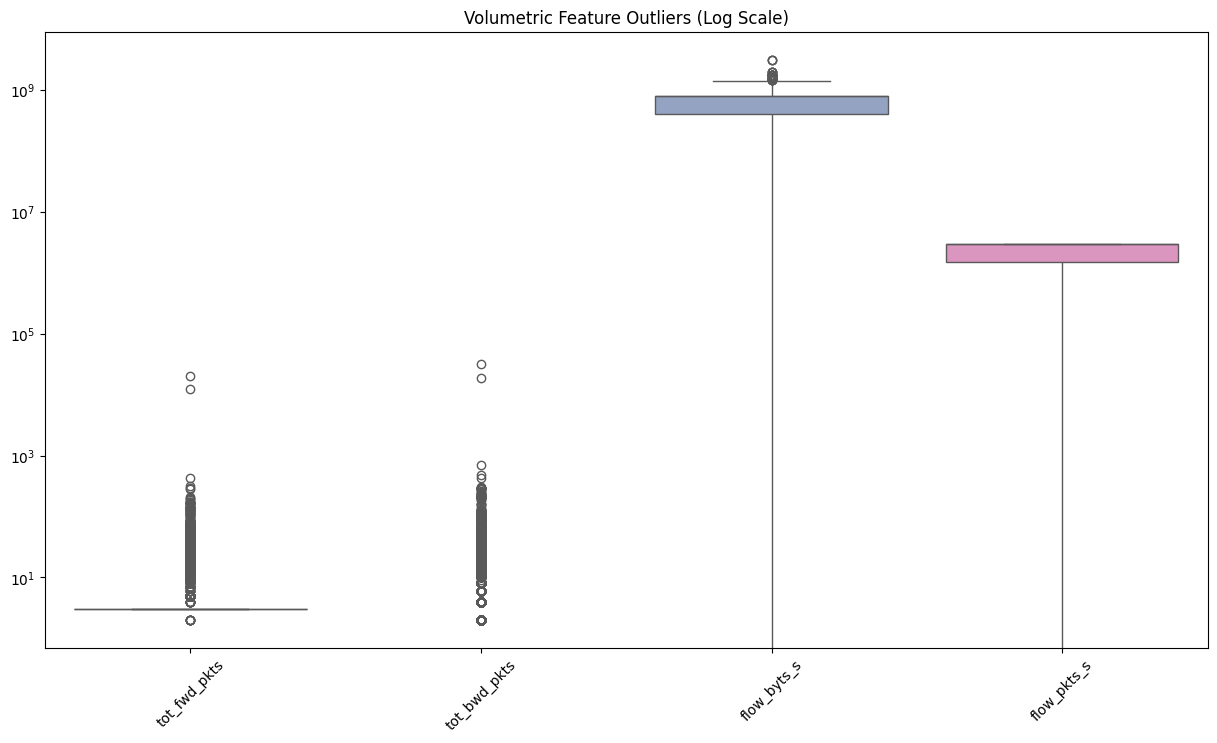

In [ ]:
# Volumetric and Rate features
vol_cols = ['tot_fwd_pkts', 'tot_bwd_pkts', 'flow_byts_s', 'flow_pkts_s']

plt.figure(figsize=(15, 8))
sns.boxplot(data=df[vol_cols], palette="Set2")
plt.yscale('log') # Essential for visualizing massive spikes vs normal traffic
plt.title('Volumetric Feature Outliers (Log Scale)')
plt.xticks(rotation=45)

This cell generates two scatter plots to analyze the relationship between `flow_duration` and packet volume (`tot_fwd_pkts` and `tot_bwd_pkts`). Both axes are set to a logarithmic scale. The plots help in identifying DDoS attack signatures:
- **First plot (Duration vs. Total Forward Packets)**: Shows how the total number of packets sent in the forward direction relates to the flow's duration. High volume in a short duration can indicate a flood attack.
- **Second plot (Duration vs. Total Backward Packets)**: Similar to the first, but for backward packets. Comparing these two plots can reveal asymmetries, a key characteristic of many DDoS attacks.

Text(0.5, 1.0, 'DDoS Signature Identification: Duration vs. Volume')

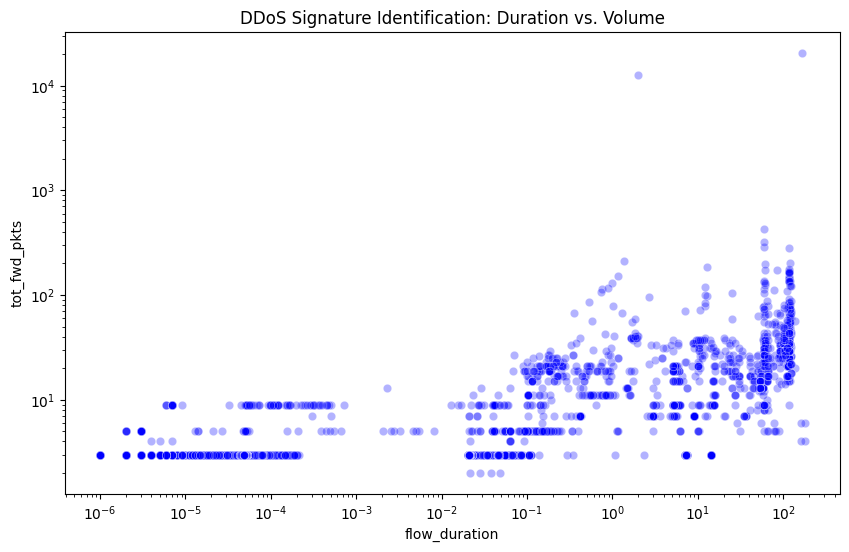

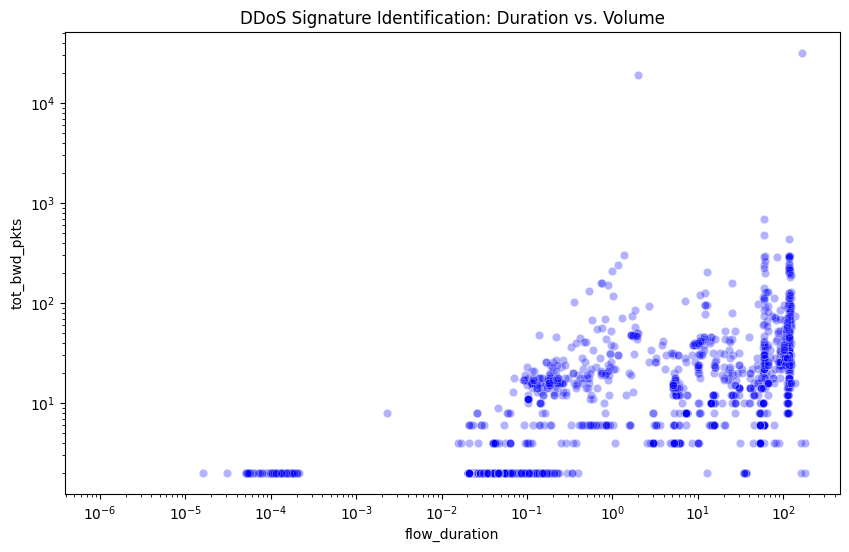

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plot of Duration vs Total Forward Packets
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='flow_duration', y='tot_fwd_pkts', alpha=0.3, color='blue')

plt.xscale('log')
plt.yscale('log')
plt.title('DDoS Signature Identification: Duration vs. Volume')


# Scatter plot of Duration vs Total Backward Packets
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='flow_duration', y='tot_bwd_pkts', alpha=0.3, color='blue')

plt.xscale('log')
plt.yscale('log')
plt.title('DDoS Signature Identification: Duration vs. Volume')

This cell performs an asymmetry analysis by plotting `tot_fwd_pkts` against `tot_bwd_pkts` using a scatter plot with logarithmic scales. It includes a dashed green line representing 'Standard Symmetric Traffic' (a 1:1 ratio), where forward and backward packet counts are roughly equal, which is typical for many legitimate TCP connections. A text annotation highlights the 'Unidirectional Flood Signature' zone, which corresponds to flows with high forward packet counts but very low backward packet counts (points hugging the x-axis). This visualization is very effective for detecting flood attacks where traffic flows predominantly in one direction.

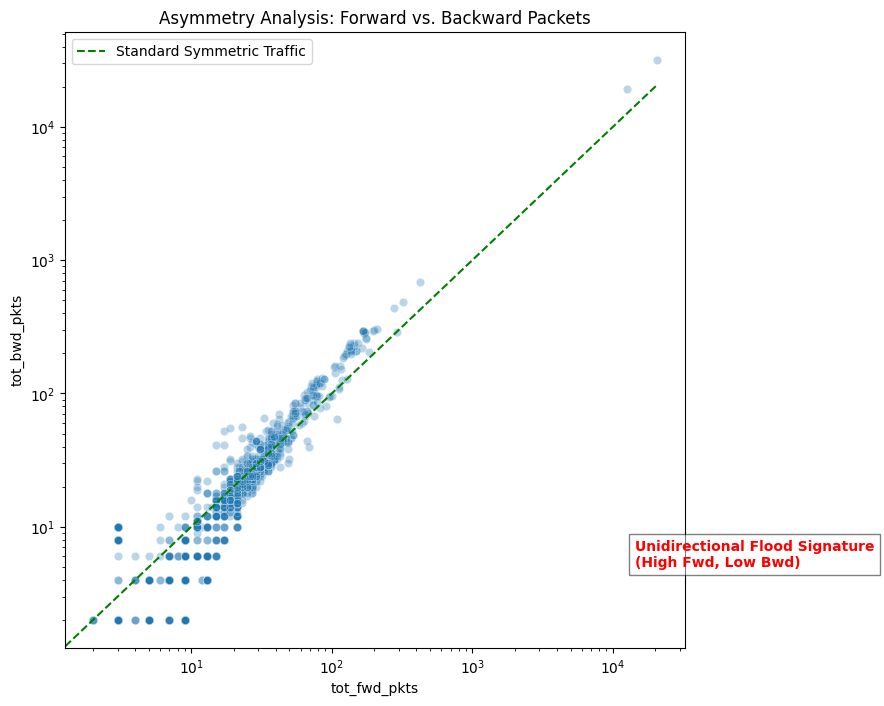

In [ ]:
plt.figure(figsize=(8, 8))
# Normal traffic should follow the 1:1 ratio line
sns.scatterplot(data=df, x='tot_fwd_pkts', y='tot_bwd_pkts', alpha=0.3)

# Add the 1:1 Ratio Line (Standard TCP)
plt.plot([0, df['tot_fwd_pkts'].max()], [0, df['tot_fwd_pkts'].max()], 'g--', label='Standard Symmetric Traffic')

# Label the X-axis huggers (Unidirectional Floods)
plt.text(df['tot_fwd_pkts'].max()*0.7, 5, 'Unidirectional Flood Signature\n(High Fwd, Low Bwd)',
         color='red', weight='bold', bbox=dict(facecolor='white', alpha=0.5))

plt.xscale('log')
plt.yscale('log')
plt.title('Asymmetry Analysis: Forward vs. Backward Packets')
plt.legend()

### Visualizing TCP Flags (Categorical/Frequency)

This cell visualizes the total frequency of various TCP flags (`fin_flag_cnt`, `syn_flag_cnt`, `rst_flag_cnt`, `psh_flag_cnt`, `ack_flag_cnt`) across all network flows. It first 'melts' the DataFrame to prepare it for a bar plot, allowing all flag counts to be aggregated. A bar plot is then generated, with the y-axis on a logarithmic scale to handle potentially large differences in flag counts. This visualization helps in identifying unusual patterns in flag usage, such as an excessive number of SYN flags without corresponding ACKs (indicating a SYN flood) or a high number of RST flags (indicating forced connection resets).

/tmp/ipython-input-3645733870.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Flag Type', y='Count', data=df_flags, estimator=sum, palette="viridis")


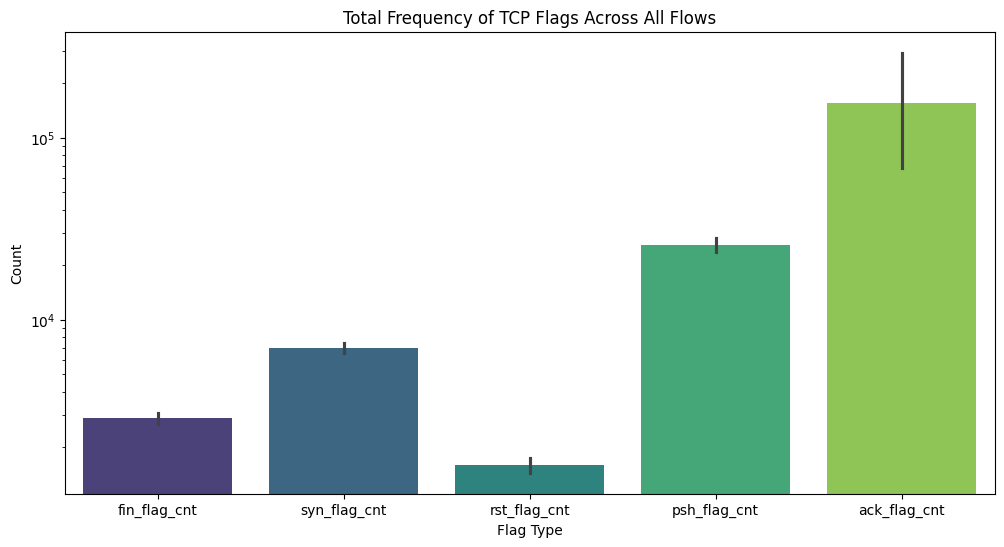

In [46]:
# Flag related features
flag_cols = ['fin_flag_cnt', 'syn_flag_cnt', 'rst_flag_cnt', 'psh_flag_cnt', 'ack_flag_cnt']

# Melt the dataframe to make it suitable for a barplot
df_flags = df[flag_cols].melt(var_name='Flag Type', value_name='Count')

plt.figure(figsize=(12, 6))
sns.barplot(x='Flag Type', y='Count', data=df_flags, estimator=sum, palette="viridis")
plt.title('Total Frequency of TCP Flags Across All Flows')
plt.yscale('log')

### Correlation Heatmap (Feature Relationships)

This cell generates a correlation heatmap for a subset of key features (`timing_cols`, `vol_cols`, `flag_cols`, `pkt_len_mean`, `down_up_ratio`).
- `corr = df[subset_cols].corr()`: Calculates the pairwise correlation between the selected features.
- `sns.heatmap()`: Visualizes this correlation matrix. The `annot=True` parameter displays the correlation coefficients on the heatmap, `fmt=".2f"` formats them to two decimal places, and `cmap='coolwarm'` sets the color scheme, with `square=True` ensuring a square aspect ratio.

This heatmap is crucial for understanding the relationships between different network flow characteristics. Highly correlated features (values close to 1 or -1) might be redundant, while low correlations suggest independent features. This analysis can help in feature selection and understanding the underlying structure of the dataset.

Text(0.5, 1.0, 'Correlation Matrix of Key Flow Features')

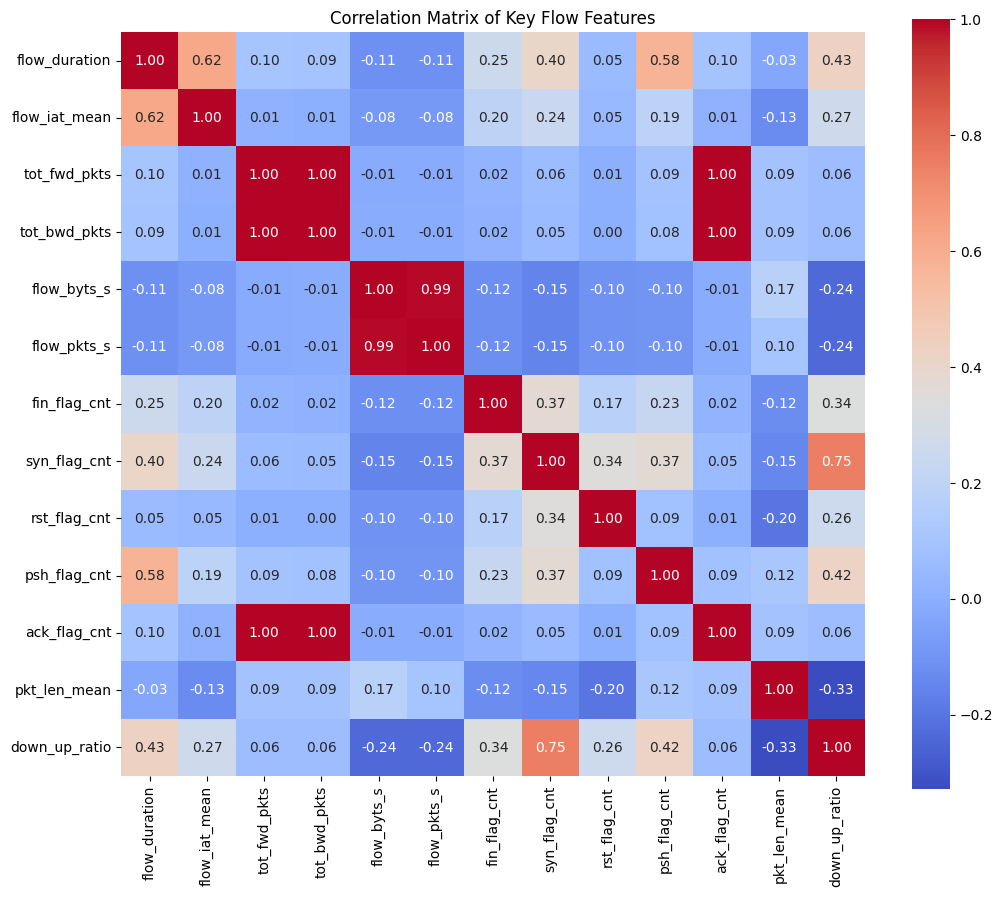

In [ ]:
# Selecting a subset of diverse features for a cleaner heatmap
subset_cols = timing_cols + vol_cols + flag_cols + ['pkt_len_mean', 'down_up_ratio']
corr = df[subset_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix of Key Flow Features')